# Лабораторная работа № 4
## Сети с радиальными базисными элементами

Цель работы: исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и аппроксимации функции.

|Студент| Попов И.П.|
|-|-|
|Группа| М8О-406Б-20|
|Вариант| 17|

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

###  Применение многослойной нейронной сети в задачах классификации

Функция, которая генерирует координаты точек эллипса по параметрическим уравнениям

In [2]:
def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

Функция, которая генерирует координаты точек параболы по параметрическим уравнениям

In [3]:
def parabola(t, p, x0, y0):
    x = x0 + p * t**2
    y = y0 + t
    return x, y

Функция, выполняющая поворот точек вокруг начала координат

In [4]:
def rotate(x, y, alpha):
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

Генерирация равномерно распределенных значений от 0 до 2π для эллипсов и от -5 до 5 для параболы с общим количеством точек равным 200

In [5]:
t_for_ellipse = np.linspace(0, 2 * np.pi, 200)
t_for_parabola = np.linspace(-5, 5, 200)

Классы, выраженные эллипсами и параболой

In [6]:
# Класс 1
x1, y1 = ellipse(t_for_ellipse, a=0.4, b=0.15, x0=0.1, y0=-0.15)
x1, y1 = rotate(x1, y1, np.pi / 6.)

In [7]:
# Класс 2
x2, y2 = ellipse(t_for_ellipse, a=0.7, b=0.5, x0=0., y0=0.)
x2, y2 = rotate(x2, y2, -np.pi / 3.)

In [8]:
# Класс 3
x3, y3 = parabola(t_for_parabola, p=1, x0=-0.8, y0=0.)
x3, y3 = rotate(x3, y3, np.pi / 2.)

Создание списков points для каждого класса. Далее, создаются списки классов classes1, classes2, classes3 в формате one-hot encoding для каждого класса. Наконец, переменные X и Y объединяют все точки и соответствующие им классы для последующего использования в обучении многослойной нейронной сети.

In [9]:
points1 = [[x, y] for x, y in zip(x1, y1)]
points2 = [[x, y] for x, y in zip(x2, y2)]
points3 = [[x, y] for x, y in zip(x3, y3)]

classes1 = [[1., 0., 0.] for _ in range(len(points1))]
classes2 = [[0., 1., 0.] for _ in range(len(points2))]
classes3 = [[0., 0., 1.] for _ in range(len(points3))]

X = points1 + points2 + points3
Y = classes1 + classes2 + classes3

Разделение данных на обучающий (x_train, y_train) и тестовый (x_test, y_test) наборы. 20% данных будут использоваться для тестирования, а 80% - для обучения. Параметр random_state=42 фиксирует случайное разбиение, обеспечивая воспроизводимость результатов.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Преобразование в тензоры

In [11]:
x_train = torch.FloatTensor(np.array(x_train))
y_train = torch.FloatTensor(np.array(y_train))

x_test = torch.FloatTensor(np.array(x_test))
y_test = torch.FloatTensor(np.array(y_test))

Через train_loader будем загружать на обучение батчи размером 10% от обучающего датасета.

In [12]:
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size = int(len(train_dataset) * 0.1)
train_loader = DataLoader(train_dataset, batch_size)

`l_norm` реализует вычисление $L_p$-нормы тензора `x` с параметром $p$, по умолчанию равным 2.

`rbf_gaussian` представляет собой радиально-базисную функцию гауссовского типа. Эта функция вычисляет значение $e^{-1/x^2}$.

In [13]:
def l_norm(x, p=2):
    return torch.norm(x, p=p, dim=-1)

def rbf_gaussian(x):
    return torch.exp(-1./x.pow(2))

Реализация класса RadialBasisFunctionNetwork, который представляет собой слой с радиальными базисными функциями.

In [14]:
class RadialBasisFunctionNetwork(nn.Module):
    def __init__(self, in_features: int, num_kernels: int, out_features: int):
        super(RadialBasisFunctionNetwork, self).__init__()
        self.in_features = in_features
        self.num_kernels = num_kernels 
        self.out_features = out_features
        self._make_parameters()

    # Инициализация параметров слоя
    def _make_parameters(self):
        self.weights = nn.Parameter(torch.zeros(self.out_features, self.num_kernels, dtype=torch.float32))
        self.kernels_centers = nn.Parameter(torch.zeros(self.num_kernels, self.in_features, dtype=torch.float32))
        self.log_shapes = nn.Parameter(torch.zeros(self.num_kernels, dtype=torch.float32))
        self.reset()

    # Сброс параметров с заданными гиперпараметрами
    def reset(self, upper_bound_kernels: float = 1.0, std_shapes: float = 0.1, gain_weights: float = 1.0):
        nn.init.uniform_(self.kernels_centers, a=-upper_bound_kernels, b=upper_bound_kernels)
        nn.init.normal_(self.log_shapes, mean=0.0, std=std_shapes)
        nn.init.xavier_uniform_(self.weights, gain=gain_weights)

    def forward(self, input: torch.Tensor):
        batch_size = input.size(0)

        # Рассчитываем расстояния до центров
        mu = self.kernels_centers.expand(batch_size, self.num_kernels, self.in_features)
        diff = input.view(batch_size, 1, self.in_features) - mu

        # Применяем нормировочную функцию
        r = l_norm(diff)

        # Применяем параметр формы
        eps_r = self.log_shapes.exp().expand(batch_size, self.num_kernels) * r

        # Применяем радиально-базисную функцию
        rbfs = rbf_gaussian(eps_r)

        # В качестве ответа даем линейную комбинацию
        out = self.weights.expand(batch_size, self.out_features, self.num_kernels) * rbfs.view(batch_size, 1, self.num_kernels)

        return out.sum(dim=-1)

    # getter для центров базисных функций слоя
    @property
    def get_kernels_centers(self):
        return self.kernels_centers.detach()

    # getter для весов слоя
    @property
    def get_weights(self):
        return self.weights.detach()

    # getter для параметров формы слоя, представленные в экспоненциальной форме
    @property
    def get_shapes(self):
        return self.log_shapes.detach().exp()

Создается экземпляр класса RadialBasisFunctionNetwork с двумя входными признаками, десятью базисными функциями и тремя выходными признаками.
Функция потерь - MSE

In [15]:
rbf_net_classifier = RadialBasisFunctionNetwork(2, 10, 3)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(rbf_net_classifier.parameters())

Внутри цикла по эпохам, для каждого батча, модель обновляется, вычисляется значение функции потерь и производится оптимизация параметров.

In [16]:
def fit(model, train_loader, criterion, optimizer, epochs):
    losses = []

    running_loss = 0.0
    processed_data = 0

    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f}"
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outp = model(inputs)

            loss = criterion(outp, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            processed_data += inputs.size(0)

        train_loss = running_loss / processed_data
        losses.append(train_loss)
        print(log_template.format(ep=epoch+1, t_loss=loss))
    return losses

Выполняет предсказание с использованием модели, обученной на тестовых данных.

In [17]:
def predict(model, x_test):
    with torch.no_grad():
        model.eval()
        outp = model(x_test)
    return outp

Процесс обучения, который включает 2500 эпох.

In [ ]:
losses = fit(rbf_net_classifier, train_loader, loss_function, optimizer, 2500)

График функции потерь (ошибка - MSE)

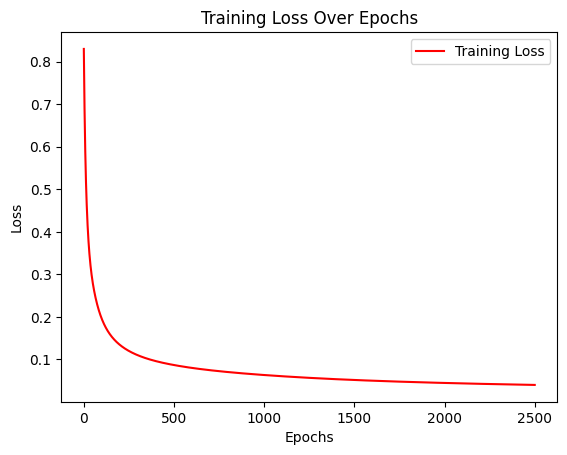

In [19]:
plt.plot(losses, color='red', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Формируется сетка точек для области [-1, 1] x [-1, 1] с использованием np.linspace, и каждая точка представляется парой координат x и y. Затем эти точки преобразуются в тензор модель используется для предсказания цветовых компонент RGB для каждой точки. Результаты предсказаний сохраняются в переменной predicted_RGB, которая изменяется в форму (200, 200, 3) для удобства последующего использования.

In [20]:
x_test = [[x, y] for x in np.linspace(-1, 1, 200) for y in np.linspace(-1, 1, 200)]

x_test = torch.FloatTensor(np.array(x_test))

predicted_RGB = predict(rbf_net_classifier, x_test)
predicted_RGB = predicted_RGB.reshape((200, 200, 3))

Визуализация приведенных выше классов.

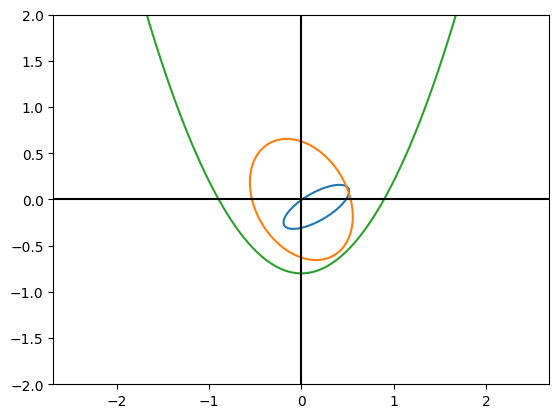

In [21]:
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

Разделение области на классы, которые линейно неразделимы

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


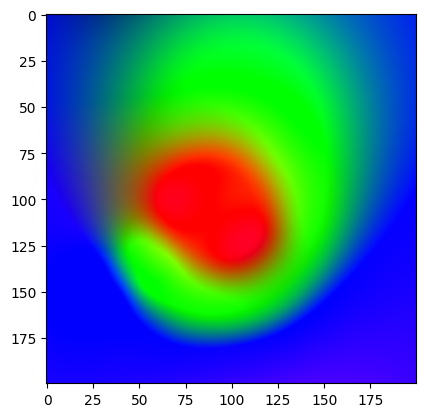

In [22]:
rotated_image = np.rot90(predicted_RGB)
flipped_image = np.fliplr(rotated_image)
plt.imshow(flipped_image)

###  Применение многослойной нейронной сети в задачах аппроксимации функций

Функция для аппроксимации

In [23]:
def function(t):
    return np.cos(-5 * t**2 + 10 * t - 5)

Создадим два набора точек - один разряженный, другой - эталонный

In [24]:
t1 = np.linspace(0, 2.5, 150)
f1 = function(t1)

t2 = np.linspace(0, 2.5, 2000)
f2 = function(t2)

Преобразуем данные для обучения и тестированияв тензоры. Изменяем форму данных, чтобы соответствовать ожидаемому формату для использования в многослойной нейронной сети. Создается датасет для обучения, который будет использоваться при обучении сети.

In [25]:
x_train2 = torch.FloatTensor(t1)
y_train2 = torch.FloatTensor(f1)

x_train2 = x_train2.view(-1, 1)
y_train2 = y_train2.view(-1, 1)
train_dataset2 = TensorDataset(x_train2, y_train2)

x_test2 = torch.FloatTensor(t2)
x_test2 = x_test2.view(-1, 1)

Экземпляр модели для решения задачи аппроксимации функции с одним входным признаком, 35 базисными функциями и одним выходным признаком.

In [26]:
rbf_net_approximator = RadialBasisFunctionNetwork(1, 35, 1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(rbf_net_approximator.parameters())

In [27]:
batch_size = 10
train_loader2 = DataLoader(train_dataset2, batch_size)

In [ ]:
losses2 = fit(rbf_net_approximator, train_loader2, loss_function, optimizer, 2500)

График функции потерь (ошибка - MSE)

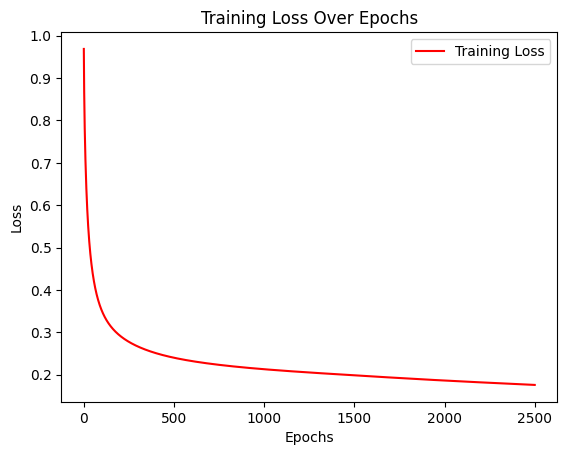

In [29]:
plt.plot(losses2, color='red', label='Training Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

Получение предсказанных значений для тестового набора данных

In [30]:
f2_pred = predict(rbf_net_approximator, x_test2)

Сравнение разреженного варианта, приближения и истинной функции

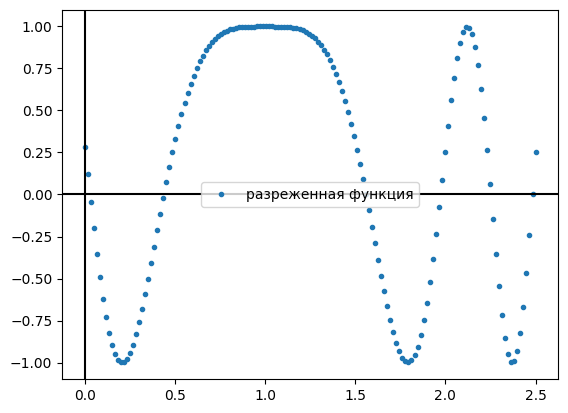

In [31]:
plt.plot(t1, f1, '.', label='разреженная функция')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

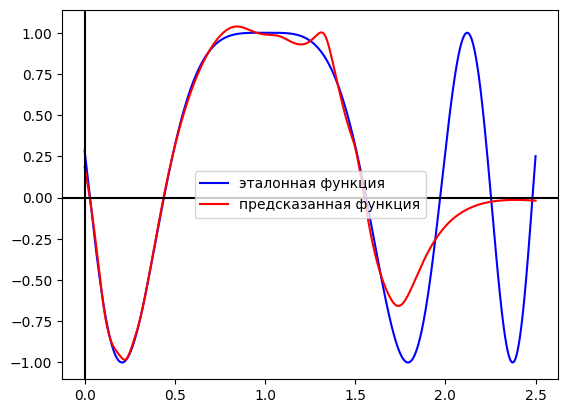

In [32]:
plt.plot(t2, f2, color="blue", label='эталонная функция')
plt.plot(t2, f2_pred, color="red", label='предсказанная функция')

plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.legend()
plt.show()

**Выводы:** В ходе данной работы была построена сеть на основе радиально-базисной функции, которая успешно применялась для решения задач классификации и аппроксимации функций. После обучения на протяжении 2500 эпох получены результаты, которые свидетельствует об эффективности примененного метода. 

Стоит отметить, что несмотря на хорошую способность к аппроксимации сложных нелинейных функций, выбор правильных центров RBF является очень важным шагом в процессе обучения и может доставлять немало проблем своим влиянием на производительность сети.